In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
datasets=image_dataset_from_directory("./PlantVillage",batch_size=BATCH_SIZE,image_size=(IMAGE_SIZE,IMAGE_SIZE),shuffle=True,seed=42)

Found 2152 files belonging to 3 classes.


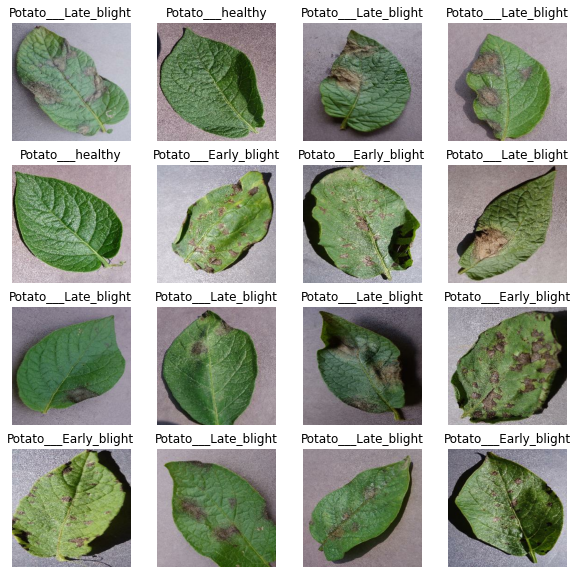

In [4]:
plt.figure(figsize=(10,10))
class_name=datasets.class_names
for image_data,label_data in datasets.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_data[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[label_data[i].numpy()])
        plt.axis("off")

train_data=0.8
valid_data=0.1
test_data=0.1

In [5]:
len(datasets)*0.8

54.400000000000006

In [6]:
len(datasets)*0.1

6.800000000000001

In [7]:
len(datasets)*0.1

6.800000000000001

In [8]:
def test_train_split(datasets,train_data=0.8,valid_data=0.1,test_data=0.1,shuffle=True,Shuffle_seed=42,shuffle_size=10000):
    if shuffle:
        datasets=datasets.shuffle(shuffle_size,seed=Shuffle_seed)
    dataset_len=len(datasets)
    train_len=int(dataset_len*train_data)
    test_len=int(dataset_len*test_data)
    valid_len=int(dataset_len*valid_data)
    train_data=datasets.take(train_len)
    test_data=datasets.skip(train_len).take(test_len)
    valid_data=datasets.skip(train_len).skip(test_len).take(valid_len)
    
    return train_data,test_data,valid_data


    
    

In [9]:
train_data,test_data,valid_data=test_train_split(datasets)

In [10]:
len(train_data)

54

In [11]:
len(test_data)

6

In [12]:
len(valid_data)

6

In [13]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data=valid_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale=Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [15]:
data_augmention=Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3)
])

In [16]:
train_data=train_data.map(lambda x, y: (data_augmention(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

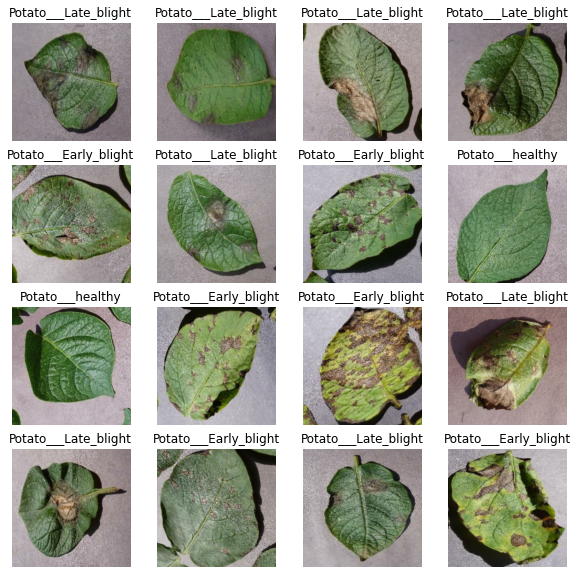

In [17]:
plt.figure(figsize=(10,10))

for image_data,label_data in train_data.take(1):
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(image_data[i].numpy().astype("uint8"))
        plt.title(class_name[label_data[i].numpy()])
        plt.axis("off")

In [18]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model=Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
    
    
])

In [19]:
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [21]:
model.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [22]:
model.fit(train_data,batch_size=BATCH_SIZE,validation_data=valid_data,epochs=EPOCHS)

Epoch 1/50
54/54 [==============================] - 52s 820ms/step - loss: 0.7315 - accuracy: 0.6796 - val_loss: 0.5666 - val_accuracy: 0.8021
Epoch 2/50
54/54 [==============================] - 22s 394ms/step - loss: 0.4579 - accuracy: 0.8415 - val_loss: 0.5737 - val_accuracy: 0.6510
Epoch 3/50
54/54 [==============================] - 18s 339ms/step - loss: 0.3725 - accuracy: 0.8533 - val_loss: 0.7298 - val_accuracy: 0.7812
Epoch 4/50
54/54 [==============================] - 19s 343ms/step - loss: 0.3052 - accuracy: 0.8826 - val_loss: 0.3938 - val_accuracy: 0.8698
Epoch 5/50
54/54 [==============================] - 19s 350ms/step - loss: 0.2630 - accuracy: 0.9085 - val_loss: 0.2324 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 20s 362ms/step - loss: 0.2009 - accuracy: 0.9161 - val_loss: 0.2610 - val_accuracy: 0.8958
Epoch 7/50
54/54 [==============================] - 20s 366ms/step - loss: 0.1483 - accuracy: 0.9390 - val_loss: 0.1482 - val_accuracy: 0.9583

In [23]:
model.evaluate(test_data)

6/6 [==============================] - 3s 47ms/step - loss: 0.0352 - accuracy: 0.9844


[0.03520729020237923, 0.984375]

actual:Potato___Early_blight
pred:Potato___Early_blight
conf:79.07774448394775


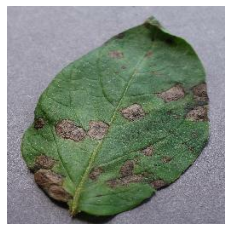

In [24]:

for image,label in test_data.take(1):
        pred=model.predict(image)
        
        plt.imshow(image[0].numpy().astype("uint8"))
        print(f"actual:{class_name[label[0]]}\npred:{class_name[pred[0].argmax()]}\nconf:{100*max(pred[0])}")
        plt.axis("off")

In [25]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

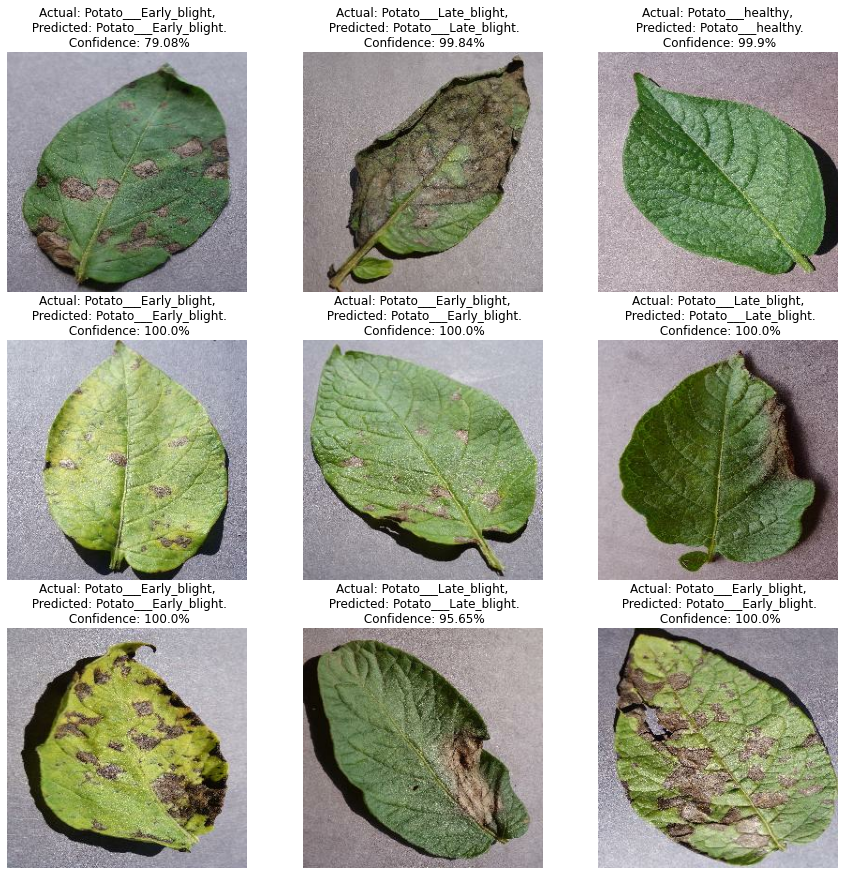

In [30]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        predicted_class=str(predicted_class)
        confidence=str(confidence)
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
model.save("./1")

INFO:tensorflow:Assets written to: ./1\assets


In [28]:
model.save("../potatoes.h5")

In [3]:
model=tf.keras.models.load_model("./saved_models/1/")

In [4]:
model.save("./patates.h5")